In [1]:
import dill
from train_valid_test_loader import load_train_valid_test_datasets

In [2]:
dill_file = open('k=2Dec4Model', 'rb')
best_colab_model = dill.load(dill_file)
dill_file.close()

In [3]:
best_colab_model

In [4]:
train_tuple, valid_tuple, test_tuple, n_users, n_items = \
        load_train_valid_test_datasets()

[    0     1     2 ... 89989 89990 89991]


In [5]:
print(train_tuple)

(array([662, 298,  90, ..., 574, 757, 503]), array([761,  90, 349, ..., 505, 472, 204]), array([5, 4, 4, ..., 2, 5, 3]))


In [12]:
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [7]:
df_user = pd.read_csv('data_movie_lens_100k/user_info.csv')
df_movie = pd.read_csv('data_movie_lens_100k/movie_info.csv')
df_test_ratings = pd.read_csv('data_movie_lens_100k/ratings_masked_leaderboard_set.csv')
movies_raw = list(df_movie['title'].values)
bad_chars = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '(', ')', 'The', ',']
movies = []
for movie in movies_raw:
    for c in bad_chars:
        movie = movie.replace(c, '')
    movies.append(movie)
title_count = CountVectorizer().fit_transform(movies).toarray()
test_users_ids = df_test_ratings['user_id']
test_movie_ids = df_test_ratings['item_id']


In [8]:
y_true_train = []
x_vals_train = []
scaler = MinMaxScaler()
for u, m, r in zip(train_tuple[0], train_tuple[1], train_tuple[2]):
    x = [title_count[m].tolist() + [df_movie['release_year'][m]] + [df_user['age'][u]] + [df_user['is_male'][u]]]
    y_true_train.append(r)
    x_vals_train.append(x)
y_true_train = np.asarray(y_true_train).squeeze()
x_vals_train = np.asarray(x_vals_train).squeeze()
x_vals_train = scaler.fit_transform(x_vals_train)

[[0.97368421 0.28787879 1.        ]
 [0.93421053 0.33333333 1.        ]
 [1.         0.72727273 1.        ]
 ...
 [0.38157895 0.39393939 1.        ]
 [0.53947368 0.3030303  1.        ]
 [0.63157895 0.5        0.        ]]


In [9]:
y_true_valid = []
x_vals_valid = []
scaler = MinMaxScaler()
for u, m, r in zip(valid_tuple[0], valid_tuple[1], valid_tuple[2]):
    x = [title_count[m].tolist() + title_count[m].tolist() + [df_movie['release_year'][m]] + [df_user['age'][u]] + [df_user['is_male'][u]]]
    y_true_valid.append(r)
    x_vals_valid.append(x)
y_true_valid = np.asarray(y_true_valid).squeeze()
x_vals_valid = np.asarray(x_vals_valid).squeeze()
x_vals_valid = scaler.fit_transform(x_vals_valid)

In [ ]:
auc_train = []
auc_valid = []
alphas = np.logspace(-4, 4, 9)
for alpha in alphas:
    print(alpha)
    model = MLPClassifier(random_state=1, max_iter=300, solver='adam', hidden_layer_sizes=(500, 250, 100, 10))
    model.fit(x_vals_train, y_true_train)
    y_hat_train = model.predict(x_vals_train)
    y_hat_valid = model.predict(x_vals_valid)
    auc_train.append(auc(y_true_train, y_hat_train))
    auc_valid.append(auc(y_true_valid, y_hat_valid))

0.0001


[3.3936747  3.44421737 3.46796459 ... 4.01944606 3.8381757  3.80692407]
0.9235411538512621


Text(0.5, 1.0, 'MAE across alpha values')

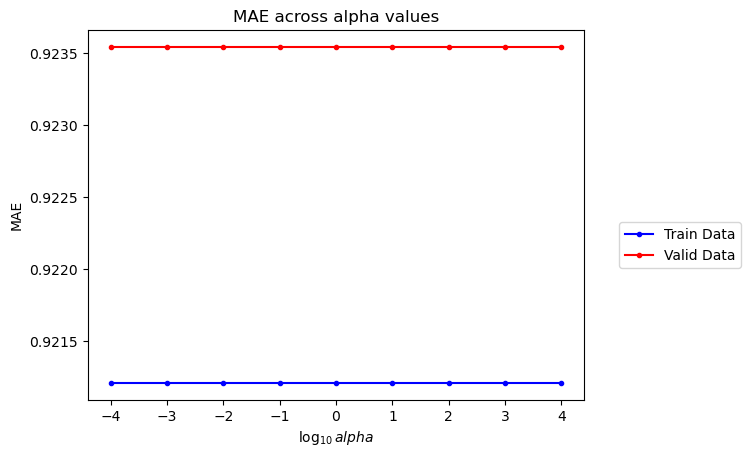

In [ ]:
plt.plot(np.log10(alphas), auc_train, '.-', color='blue', label='Train Data')
plt.plot(np.log10(alphas), auc_valid, '.-', color='red', label='Valid Data')
plt.ylabel("AUC ROC")
plt.legend(bbox_to_anchor=(1.33, 0.5))
plt.xlabel("$\log_{10} alpha$")
plt.title("AUC across alpha values")